IT1244 Project: Eunice, Shervon, Jun Hui, Kathleen

Dataset chosen: Movie Review

Dataset Information: This dataset contains movie reviews. It is intended to serve as a benchmark for sentiment classification. The positive and negative reviews can be found in data/pos.zip and data/neg.zip, respectively. You will find each review as a text file after unzipping the zip files.

Task: Make sure to look at relevant research papers that talk about document classification, because this task is highly relevant to such problems. You need to do proper cross validation. Make sure to analyze the test samples where the model makes mistakes in prediction and tell us about what kind of challenging properties these mistaken documents have.


Mounting Google Drive for easy access to dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To start, we will unzip the positive and negative reviews in the movie review dataset and label them accordingly.

In [ ]:
import zipfile
import os
import nltk

# Paths to your zip files
pos_zip_path = '/content/drive/MyDrive/Movie Description/data/pos.zip'
neg_zip_path = '/content/drive/MyDrive/Movie Description/data/neg.zip'

# Function to extract reviews from zip files
def extract_reviews(zip_path, target_dir):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(target_dir)

# Create directories for extracted files
extract_reviews(pos_zip_path, '/content/pos_reviews')
extract_reviews(neg_zip_path, '/content/neg_reviews')

# List the extracted files to confirm
print("Positive reviews:", os.listdir('/content/pos_reviews')[:5])
print("Negative reviews:", os.listdir('/content/neg_reviews')[:5])


Positive reviews: ['pos']
Negative reviews: ['neg']


In [ ]:
# List the contents of the extracted positive and negative review directories
print("Contents of positive reviews directory:", os.listdir('/content/pos_reviews/pos'))
print("Contents of negative reviews directory:", os.listdir('/content/neg_reviews/neg'))


Contents of positive reviews directory: ['23199.txt', '6123.txt', '1524.txt', '12314.txt', '15822.txt', '11299.txt', '4345.txt', '22104.txt', '5796.txt', '4313.txt', '8515.txt', '6551.txt', '12464.txt', '17284.txt', '17808.txt', '1751.txt', '7314.txt', '23282.txt', '6528.txt', '15145.txt', '2456.txt', '15856.txt', '21224.txt', '13369.txt', '17493.txt', '9124.txt', '2407.txt', '15247.txt', '24752.txt', '21921.txt', '18161.txt', '236.txt', '15259.txt', '995.txt', '15783.txt', '4019.txt', '6010.txt', '22413.txt', '3074.txt', '8514.txt', '18152.txt', '18235.txt', '17478.txt', '201.txt', '3077.txt', '17577.txt', '263.txt', '5410.txt', '17012.txt', '11486.txt', '3193.txt', '8390.txt', '13174.txt', '17059.txt', '14212.txt', '19216.txt', '18868.txt', '630.txt', '2240.txt', '23941.txt', '20745.txt', '20392.txt', '21054.txt', '8825.txt', '23454.txt', '12156.txt', '2656.txt', '482.txt', '14171.txt', '1448.txt', '14961.txt', '4267.txt', '1478.txt', '23807.txt', '15657.txt', '13695.txt', '20463.txt

We will now load the reviews from the positive and negative reviews directory.

In [ ]:
# Function to load reviews from the extracted subdirectories
def load_reviews_from_subdirectory(directory):
    reviews = []
    subdirectory = os.path.join(directory, 'pos') if 'pos' in directory else os.path.join(directory, 'neg')
    for filename in os.listdir(subdirectory):
        with open(os.path.join(subdirectory, filename), 'r', encoding='utf-8') as f:
            reviews.append(f.read())
    return reviews

# Load the reviews from the new paths
pos_reviews = load_reviews_from_subdirectory('/content/pos_reviews')
neg_reviews = load_reviews_from_subdirectory('/content/neg_reviews')

# Combine the reviews and create labels
X = pos_reviews + neg_reviews
y = ['positive'] * len(pos_reviews) + ['negative'] * len(neg_reviews)

print(f"Loaded {len(pos_reviews)} positive reviews and {len(neg_reviews)} negative reviews.")



Loaded 25000 positive reviews and 25000 negative reviews.


In [ ]:
!pip install nltk


Firstly, we will clean the data by removing HTML tags from the reviews.

In [ ]:
# Function to remove HTML tags, like <br /> from the reviews
def remove_html_tags(text):
    # Replace <br />, <br>, and any variations of the HTML line break with an empty string
    return text.replace("<br />", " ").replace("<br>", " ")


no_html_reviews = [remove_html_tags(review) for review in X]

# Print the first few cleaned reviews
for i, review in enumerate(no_html_reviews[:5]):
    print(f"Original Review: {X[i]}")
    print(f"Cleaned Review: {review}\n")


Original Review: To those who say that this movie deserves anything below the unflaunting grace that it showed, I disagree. This is an amazing documentary about a shocking day.<br /><br />IMDB asks us to rate this movie. I beg you to consider the fact that the documentary was made. The courage that it took to shoot this film is most notable. We find that the two brothers are split up when that moment happened. They continue to document the bravest of the brave without knowing about their own and eachother's safety. To judge whether it's nobler to shoot a video of that tragedy or to save the lives as those amazing, amazing firefighters did is not mine to answer. I just know that in 30 years, a class full of children will not know one without the other.<br /><br />I submit a wholehearted 10. This is why the art of filming was created! To capture the natural emotion that real life offers. You can keep your kung-fu junk. Romance is cute. Action will never reach this level. This movie, 9/11

Now, we will expand contractions like "don't" to become "do not". This improves tokenization and handling negations later on.

In [ ]:
import re

# Contraction mapping dictionary
contractions_dict = {
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "there's": "there is",
    "we're": "we are",
    "they're": "they are",
    "i'm": "i am",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "i've": "i have",
    "you've": "you have",
    # Add more contractions as needed
}

# Function to expand contractions
def expand_contractions(text, contractions=contractions_dict):
    # Regular expression to find contractions
    contraction_pattern = re.compile('({})'.format('|'.join(contractions.keys())), flags=re.IGNORECASE|re.DOTALL)

    # Function to replace contraction with its expanded form
    def expand_match(contraction):
        match = contraction.group(0).lower()  # Get the matched contraction
        expanded_contraction = contractions.get(match)  # Find expanded form
        return expanded_contraction

    # Substitute all contractions in the text
    expanded_text = contraction_pattern.sub(expand_match, text)
    return expanded_text

expanded_contractions = [expand_contractions(review) for review in no_html_reviews]


for i, review in enumerate(expanded_contractions[:5]):
    print(f"Original Review: {no_html_reviews[i]}")
    print(f"Cleaned Review: {review}\n")


Original Review: To those who say that this movie deserves anything below the unflaunting grace that it showed, I disagree. This is an amazing documentary about a shocking day.  IMDB asks us to rate this movie. I beg you to consider the fact that the documentary was made. The courage that it took to shoot this film is most notable. We find that the two brothers are split up when that moment happened. They continue to document the bravest of the brave without knowing about their own and eachother's safety. To judge whether it's nobler to shoot a video of that tragedy or to save the lives as those amazing, amazing firefighters did is not mine to answer. I just know that in 30 years, a class full of children will not know one without the other.  I submit a wholehearted 10. This is why the art of filming was created! To capture the natural emotion that real life offers. You can keep your kung-fu junk. Romance is cute. Action will never reach this level. This movie, 9/11, will be timeless i

We will remove special characters like punctuation and make all letters lowercase to standardise how the data will look like.

In [ ]:
def remove_special_chars_and_lowercase(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    return text

cleaned_reviews = [remove_special_chars_and_lowercase(review) for review in expanded_contractions]


for i, review in enumerate(cleaned_reviews[:5]):
    print(f"Original Review: {expanded_contractions[i]}")
    print(f"Cleaned Review: {review}\n")





Original Review: To those who say that this movie deserves anything below the unflaunting grace that it showed, I disagree. This is an amazing documentary about a shocking day.  IMDB asks us to rate this movie. I beg you to consider the fact that the documentary was made. The courage that it took to shoot this film is most notable. We find that the two brothers are split up when that moment happened. They continue to document the bravest of the brave without knowing about their own and eachother is safety. To judge whether it is nobler to shoot a video of that tragedy or to save the lives as those amazing, amazing firefighters did is not mine to answer. I just know that in 30 years, a class full of children will not know one without the other.  I submit a wholehearted 10. This is why the art of filming was created! To capture the natural emotion that real life offers. You can keep your kung-fu junk. Romance is cute. Action will never reach this level. This movie, 9/11, will be timeless

We will then break down the data into manageable vectors that can be read by models in a process called tokenization.

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Example
tokenized_reviews = [tokenize_text(review) for review in cleaned_reviews]

# Print first tokenized review
for i, review in enumerate(tokenized_reviews[:5]):
    print(f"Original Review: {cleaned_reviews[i]}")
    print(f"Cleaned Review: {review}\n")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Original Review: to those who say that this movie deserves anything below the unflaunting grace that it showed i disagree this is an amazing documentary about a shocking day  imdb asks us to rate this movie i beg you to consider the fact that the documentary was made the courage that it took to shoot this film is most notable we find that the two brothers are split up when that moment happened they continue to document the bravest of the brave without knowing about their own and eachother is safety to judge whether it is nobler to shoot a video of that tragedy or to save the lives as those amazing amazing firefighters did is not mine to answer i just know that in  years a class full of children will not know one without the other  i submit a wholehearted  this is why the art of filming was created to capture the natural emotion that real life offers you can keep your kungfu junk romance is cute action will never reach this level this movie  will be timeless in that it did not glorify i

Handling negations is an important step in the preprocessing of data as well, as it improves the accuracy of classification later on by the models.

In [ ]:
# List of common negation words
negation_words = {"not", "no", "never", "n't"}

# Function to handle negations in a list of tokens
def handle_negations(tokens):
    negated_tokens = []
    negation_active = False

    for token in tokens:
        # If we encounter a negation word, set the negation flag
        if token in negation_words:
            negation_active = True
        elif negation_active:
            # If negation is active, prefix the current token with "not_"
            negated_tokens.append(f"not_{token}")
            negation_active = False  # Reset negation after handling one token
        else:
            # Otherwise, just append the token as is
            negated_tokens.append(token)

    return negated_tokens

# Apply the negation handling function to all tokenized reviews
reviews_with_negations_handled = [handle_negations(review) for review in tokenized_reviews]

# Print an example
original_sentence = "This movie is no bad"

tokenized_sentence = original_sentence.lower().split()  # ['this', 'movie', 'is', 'not', 'bad']
negation_handled_sentence = handle_negations(tokenized_sentence)

# Print the original and negation-handled output
print(f"Original Tokenized Review: {tokenized_sentence}")
print(f"Review with Negations Handled: {negation_handled_sentence}")

for i, review in enumerate(reviews_with_negations_handled[:5]):
    print(f"Original Review: {tokenized_reviews[i]}")
    print(f"Negated Tokens: {review}\n")


Original Tokenized Review: ['this', 'movie', 'is', 'no', 'bad']
Review with Negations Handled: ['this', 'movie', 'is', 'not_bad']
Original Review: ['to', 'those', 'who', 'say', 'that', 'this', 'movie', 'deserves', 'anything', 'below', 'the', 'unflaunting', 'grace', 'that', 'it', 'showed', 'i', 'disagree', 'this', 'is', 'an', 'amazing', 'documentary', 'about', 'a', 'shocking', 'day', 'imdb', 'asks', 'us', 'to', 'rate', 'this', 'movie', 'i', 'beg', 'you', 'to', 'consider', 'the', 'fact', 'that', 'the', 'documentary', 'was', 'made', 'the', 'courage', 'that', 'it', 'took', 'to', 'shoot', 'this', 'film', 'is', 'most', 'notable', 'we', 'find', 'that', 'the', 'two', 'brothers', 'are', 'split', 'up', 'when', 'that', 'moment', 'happened', 'they', 'continue', 'to', 'document', 'the', 'bravest', 'of', 'the', 'brave', 'without', 'knowing', 'about', 'their', 'own', 'and', 'eachother', 'is', 'safety', 'to', 'judge', 'whether', 'it', 'is', 'nobler', 'to', 'shoot', 'a', 'video', 'of', 'that', 'tragedy

Then, we will remove stopwords as they are insignificant in sentiment analysis.

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

# Function to remove stop words from a single list of tokens (i.e., a single review)
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Apply remove_stopwords to each tokenized review
# tokenized_reviews is a list of lists, where each list is a tokenized review
filtered_reviews = [remove_stopwords(review) for review in reviews_with_negations_handled]

# Print the first few filtered reviews
for i, review in enumerate(filtered_reviews[:5]):
    print(f"Original Review: {reviews_with_negations_handled[i]}")
    print(f"Cleaned Review: {review}\n")
#I loved the the film. it beautifully analyzes Italian petty bourgeois society, how the leftists of the 70s have given up all their ideals and come to a happy arrangement
#which they don't want disturbed. For instance, the aging psychoanalyst who is jealous of his own son, and doesn't want to be reminded of his more radical youth.<br /><br />
#For a long time wanted to buy the video after having seen the movie a couple of times on the big screen and on TV, but it seems to have completely disappeared from the market,
# even in Italy no one in the book shops knew about the film. a great pity.<br /><br />The one sex scene, which everyone seems to go on about, does the film no harm.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Original Review: ['to', 'those', 'who', 'say', 'that', 'this', 'movie', 'deserves', 'anything', 'below', 'the', 'unflaunting', 'grace', 'that', 'it', 'showed', 'i', 'disagree', 'this', 'is', 'an', 'amazing', 'documentary', 'about', 'a', 'shocking', 'day', 'imdb', 'asks', 'us', 'to', 'rate', 'this', 'movie', 'i', 'beg', 'you', 'to', 'consider', 'the', 'fact', 'that', 'the', 'documentary', 'was', 'made', 'the', 'courage', 'that', 'it', 'took', 'to', 'shoot', 'this', 'film', 'is', 'most', 'notable', 'we', 'find', 'that', 'the', 'two', 'brothers', 'are', 'split', 'up', 'when', 'that', 'moment', 'happened', 'they', 'continue', 'to', 'document', 'the', 'bravest', 'of', 'the', 'brave', 'without', 'knowing', 'about', 'their', 'own', 'and', 'eachother', 'is', 'safety', 'to', 'judge', 'whether', 'it', 'is', 'nobler', 'to', 'shoot', 'a', 'video', 'of', 'that', 'tragedy', 'or', 'to', 'save', 'the', 'lives', 'as', 'those', 'amazing', 'amazing', 'firefighters', 'did', 'is', 'not_mine', 'to', 'answer

Now, we will do lemmatization - converting words into their base form.

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]


# Function to stem a list of tokens (i.e., a single review)


# Apply stemming to each tokenized review (that already has stop words removed)
lemmatized_reviews = [lemmatize_tokens(review) for review in filtered_reviews]

# Print the first few stemmed reviews
for i, review in enumerate(lemmatized_reviews[:5]):
    print(f"Original Review: {filtered_reviews[i]}")
    print(f"Lemmatized and Cleaned Review: {review}\n")



[nltk_data] Downloading package wordnet to /root/nltk_data...


Original Review: ['say', 'movie', 'deserves', 'anything', 'unflaunting', 'grace', 'showed', 'disagree', 'amazing', 'documentary', 'shocking', 'day', 'imdb', 'asks', 'us', 'rate', 'movie', 'beg', 'consider', 'fact', 'documentary', 'made', 'courage', 'took', 'shoot', 'film', 'notable', 'find', 'two', 'brothers', 'split', 'moment', 'happened', 'continue', 'document', 'bravest', 'brave', 'without', 'knowing', 'eachother', 'safety', 'judge', 'whether', 'nobler', 'shoot', 'video', 'tragedy', 'save', 'lives', 'amazing', 'amazing', 'firefighters', 'not_mine', 'answer', 'know', 'years', 'class', 'full', 'children', 'not_know', 'one', 'without', 'submit', 'wholehearted', 'art', 'filming', 'created', 'capture', 'natural', 'emotion', 'real', 'life', 'offers', 'keep', 'kungfu', 'junk', 'romance', 'cute', 'action', 'not_reach', 'level', 'movie', 'timeless', 'not_glorify', 'not_have', 'sneakpeek', 'not_have', 'blatant', 'vanities', 'lion', 'share', 'many', 'movies', 'many', 'screens', 'blare', 'class

Next, we remove rare words to reduce the size of our dataset.

In [ ]:
from collections import Counter

# Function to remove rare words from tokenized reviews
def remove_rare_words(reviews, min_freq=2):
    # Flatten all reviews into a single list of tokens and count their frequencies
    all_words = [word for review in reviews for word in review]
    word_freq = Counter(all_words)

    # Identify words that are frequent enough (appear at least `min_freq` times)
    frequent_words = {word for word, count in word_freq.items() if count >= min_freq}

    # Filter each review to remove rare words
    final_reviews = [[word for word in review if word in frequent_words] for review in reviews]

    return final_reviews

# Apply the function to the entire set of reviews
no_rare_tokens = remove_rare_words(lemmatized_reviews, min_freq=2)

# Print a few examples to check the output
for i, review in enumerate(no_rare_tokens[:5]):
    print(f"Original Review: {lemmatized_reviews[i]}")
    print(f"Removed Rare Tokens: {review}\n")



Original Review: ['say', 'movie', 'deserves', 'anything', 'unflaunting', 'grace', 'showed', 'disagree', 'amazing', 'documentary', 'shocking', 'day', 'imdb', 'asks', 'u', 'rate', 'movie', 'beg', 'consider', 'fact', 'documentary', 'made', 'courage', 'took', 'shoot', 'film', 'notable', 'find', 'two', 'brother', 'split', 'moment', 'happened', 'continue', 'document', 'bravest', 'brave', 'without', 'knowing', 'eachother', 'safety', 'judge', 'whether', 'nobler', 'shoot', 'video', 'tragedy', 'save', 'life', 'amazing', 'amazing', 'firefighter', 'not_mine', 'answer', 'know', 'year', 'class', 'full', 'child', 'not_know', 'one', 'without', 'submit', 'wholehearted', 'art', 'filming', 'created', 'capture', 'natural', 'emotion', 'real', 'life', 'offer', 'keep', 'kungfu', 'junk', 'romance', 'cute', 'action', 'not_reach', 'level', 'movie', 'timeless', 'not_glorify', 'not_have', 'sneakpeek', 'not_have', 'blatant', 'vanity', 'lion', 'share', 'many', 'movie', 'many', 'screen', 'blare', 'class', 'composure

We also remove any missing data.

In [ ]:
# can use for merged data, currently has no use
# Function to remove missing or empty reviews (which are lists of tokens)
def remove_missing_reviews(reviews):
    # Filter out reviews that are None or empty (empty lists)
    return [review for review in reviews if review and len(review) > 0]

# Apply to the lemmatized reviews
cleaned_reviews_no_missing = remove_missing_reviews(lemmatized_reviews)

# If you also have labels (y), filter them as well to match the cleaned reviews
filtered_labels = [label for review, label in zip(lemmatized_reviews, y) if review and len(review) > 0]

# Print the number of reviews before and after removing missing data
print(f"Number of reviews before: {len(no_rare_tokens)}")
print(f"Number of reviews after: {len(cleaned_reviews_no_missing)}")

# Optional: Check some reviews to see if they were filtered correctly
for i, review in enumerate(cleaned_reviews_no_missing[:5]):
    print(f"Original Review: {no_rare_tokens[i]}")
    print(f"Cleaned Review: {review}\n")



Number of reviews before: 50000
Number of reviews after: 50000
Original Review: ['say', 'movie', 'deserves', 'anything', 'grace', 'showed', 'disagree', 'amazing', 'documentary', 'shocking', 'day', 'imdb', 'asks', 'u', 'rate', 'movie', 'beg', 'consider', 'fact', 'documentary', 'made', 'courage', 'took', 'shoot', 'film', 'notable', 'find', 'two', 'brother', 'split', 'moment', 'happened', 'continue', 'document', 'bravest', 'brave', 'without', 'knowing', 'eachother', 'safety', 'judge', 'whether', 'nobler', 'shoot', 'video', 'tragedy', 'save', 'life', 'amazing', 'amazing', 'firefighter', 'not_mine', 'answer', 'know', 'year', 'class', 'full', 'child', 'not_know', 'one', 'without', 'submit', 'wholehearted', 'art', 'filming', 'created', 'capture', 'natural', 'emotion', 'real', 'life', 'offer', 'keep', 'kungfu', 'junk', 'romance', 'cute', 'action', 'not_reach', 'level', 'movie', 'timeless', 'not_glorify', 'not_have', 'not_have', 'blatant', 'vanity', 'lion', 'share', 'many', 'movie', 'many', 'sc

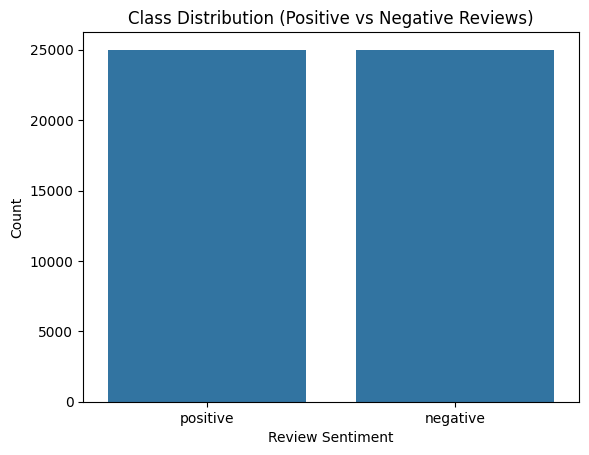

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution
sns.countplot(x=y)
plt.title("Class Distribution (Positive vs Negative Reviews)")
plt.xlabel("Review Sentiment")
plt.ylabel("Count")
plt.show()

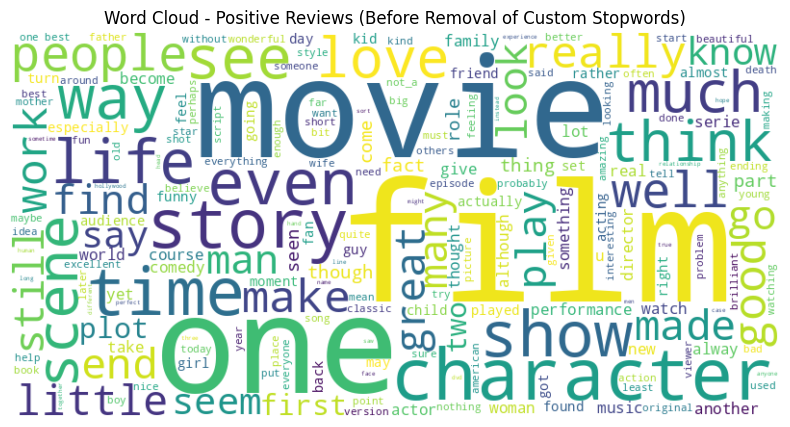

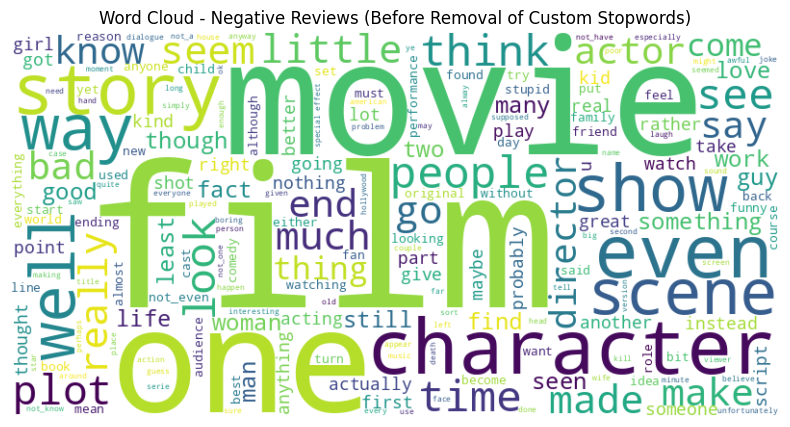

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Assuming you have a list of reviews and their corresponding labels
# Example: reviews_no_rare_words contains tokenized reviews and y contains labels ('positive' or 'negative')

# Separate positive and negative reviews based on the labels
positive_reviews = [' '.join(review) for review, label in zip(no_rare_tokens, y) if label == 'positive']
negative_reviews = [' '.join(review) for review, label in zip(no_rare_tokens, y) if label == 'negative']

# Combine all words in positive and negative reviews respectively
positive_words = ' '.join(positive_reviews)
negative_words = ' '.join(negative_reviews)

# Generate word clouds for positive reviews excluding custom stopwords
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_words)

# Generate word clouds for negative reviews excluding custom stopwords
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

# Plot positive word cloud
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Positive Reviews (Before Removal of Custom Stopwords)")
plt.axis("off")
plt.show()

# Plot negative word cloud
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Negative Reviews (Before Removal of Custom Stopwords)")
plt.axis("off")
plt.show()

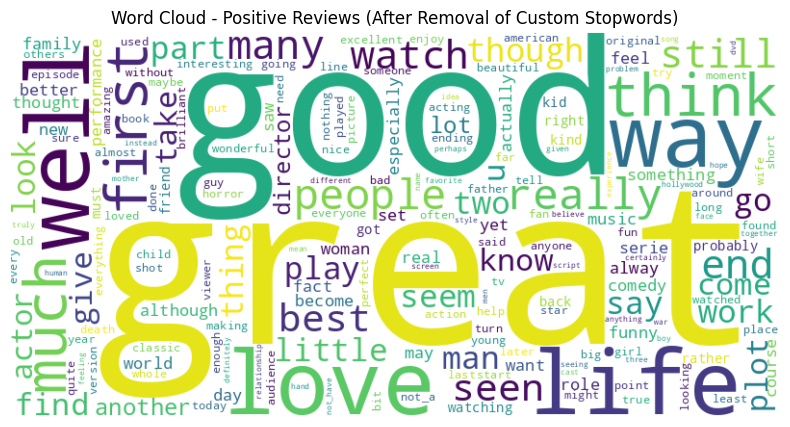

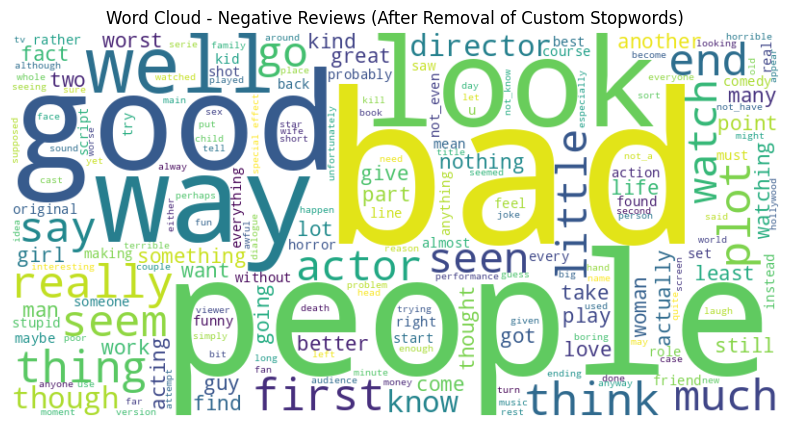

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Custom stopwords (add the words you want to exclude)
custom_stopwords = set(STOPWORDS).union({"movie", "film", "scene", "show", "one", "character", "story", "even", "time", "see","make","made"})

# Assuming you have a list of reviews and their corresponding labels
# Example: reviews_no_rare_words contains tokenized reviews and y contains labels ('positive' or 'negative')

# Separate positive and negative reviews based on the labels
positive_reviews = [' '.join(review) for review, label in zip(no_rare_tokens, y) if label == 'positive']
negative_reviews = [' '.join(review) for review, label in zip(no_rare_tokens, y) if label == 'negative']

# Combine all words in positive and negative reviews respectively
positive_words = ' '.join(positive_reviews)
negative_words = ' '.join(negative_reviews)

# Generate word clouds for positive reviews excluding custom stopwords
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(positive_words)

# Generate word clouds for negative reviews excluding custom stopwords
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(negative_words)

# Plot positive word cloud
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Positive Reviews (After Removal of Custom Stopwords)")
plt.axis("off")
plt.show()

# Plot negative word cloud
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Negative Reviews (After Removal of Custom Stopwords)")
plt.axis("off")
plt.show()

This code processes text reviews by creating a Bag of Words (BoW) matrix, excluding custom stopwords, and visualizes the most frequent words in positive and negative reviews separately. It uses a bar plot to display the top 20 words by frequency.

<ipython-input-18-23466d118be3>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=word_freq_df, palette='Blues_d')


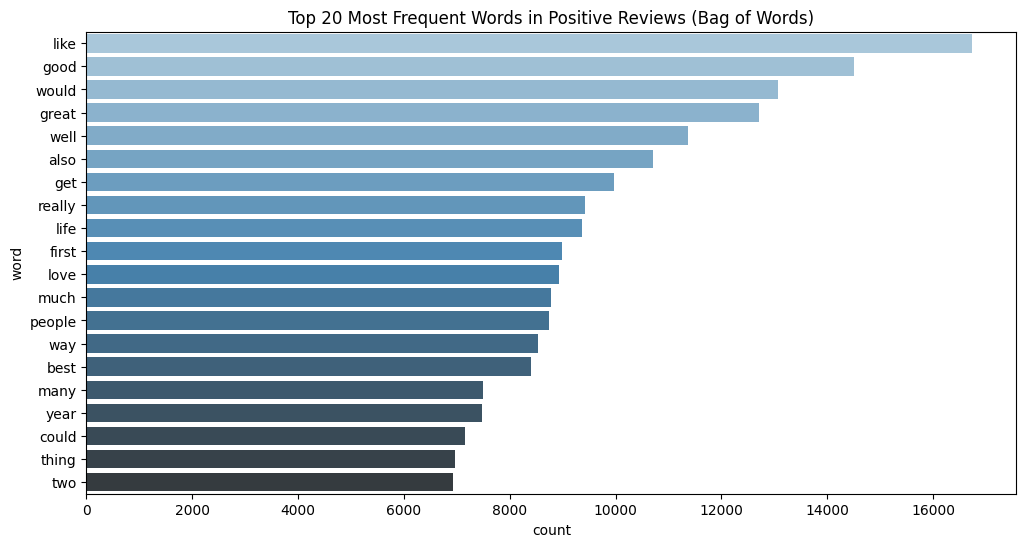

<ipython-input-18-23466d118be3>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=word_freq_df, palette='Blues_d')


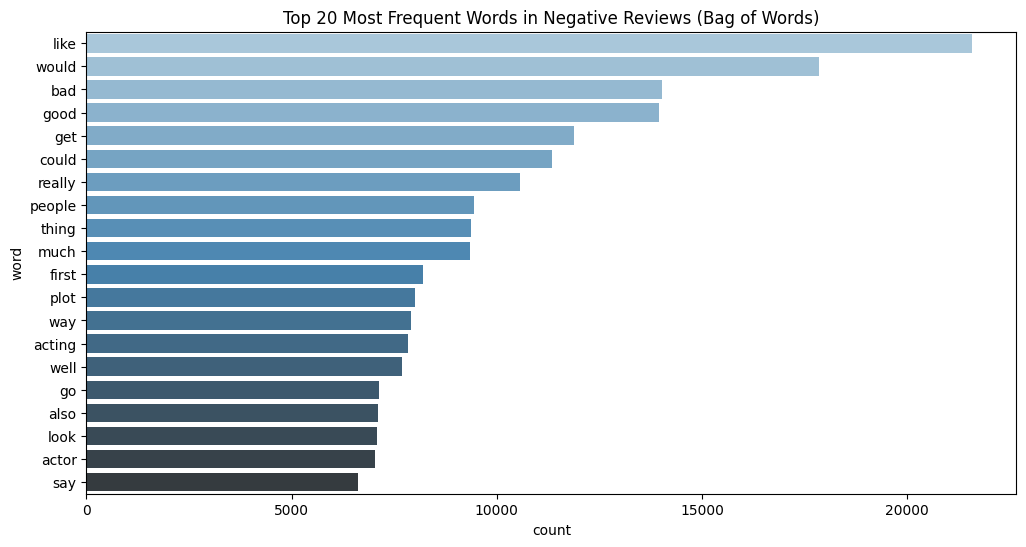

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Assuming y contains labels ('positive' or 'negative') and X_bow is the BoW matrix
# Join tokens back into strings after removing rare tokens
processed_reviews = [" ".join(review) for review in no_rare_tokens]

# Custom stopwords (add the words you want to exclude)
custom_stopwords = ["movie", "film", "scene", "show", "one", "character", "story", "even", "time", "see", "make", "made"]

# Initialize the CountVectorizer for BoW, excluding custom stopwords
bow_vectorizer = CountVectorizer(max_features=5000, stop_words=custom_stopwords)

# Fit the vectorizer and transform the reviews
X_bow = bow_vectorizer.fit_transform(processed_reviews)

# Convert labels (y) into a boolean mask for positive and negative reviews
positive_mask = [label == 'positive' for label in y]
negative_mask = [label == 'negative' for label in y]

# Split BoW matrix into positive and negative reviews
X_bow_positive = X_bow[positive_mask]
X_bow_negative = X_bow[negative_mask]

# Function to calculate and plot most frequent words
def plot_most_frequent_words(X_bow_subset, vectorizer, title):
    # Get the sum of all words across all reviews in the subset
    word_counts = X_bow_subset.toarray().sum(axis=0)

    # Create a DataFrame of word frequencies
    word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': word_counts})

    # Sort by most frequent words
    word_freq_df = word_freq_df.sort_values(by='count', ascending=False).head(20)

    # Plot the bar chart of most frequent words
    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='word', data=word_freq_df, palette='Blues_d')
    plt.title(title)
    plt.show()

# Plot for Positive Reviews
plot_most_frequent_words(X_bow_positive, bow_vectorizer, "Top 20 Most Frequent Words in Positive Reviews (Bag of Words)")

# Plot for Negative Reviews
plot_most_frequent_words(X_bow_negative, bow_vectorizer, "Top 20 Most Frequent Words in Negative Reviews (Bag of Words)")


Install the joblib library in your Python environment.

joblib is a library used for serializing (saving) and deserializing (loading) Python objects, particularly in the context of machine learning. It is commonly used to save trained models and other large data structures efficiently, allowing you to persist your work and reload it later without needing to retrain the model or recompute the data.

In [ ]:
!pip install joblib

This code creates a Term Frequency-Inverse Document Frequency (TF-IDF) matrix for the reviews, excluding custom stopwords, and visualizes the top 20 words with the highest TF-IDF scores in positive and negative reviews separately.



Save this tfidf_vectorizer object to a file named tfidf_vectorizer.pkl using the joblib library.

<ipython-input-18-284d388b58bd>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf_score', y='word', data=word_freq_df, palette='Blues_d')


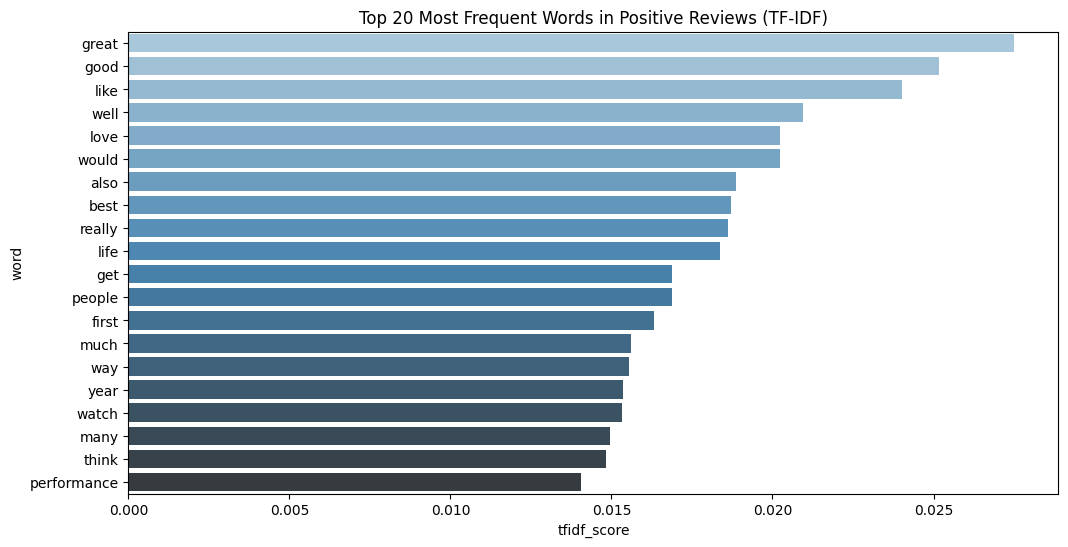

<ipython-input-18-284d388b58bd>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf_score', y='word', data=word_freq_df, palette='Blues_d')


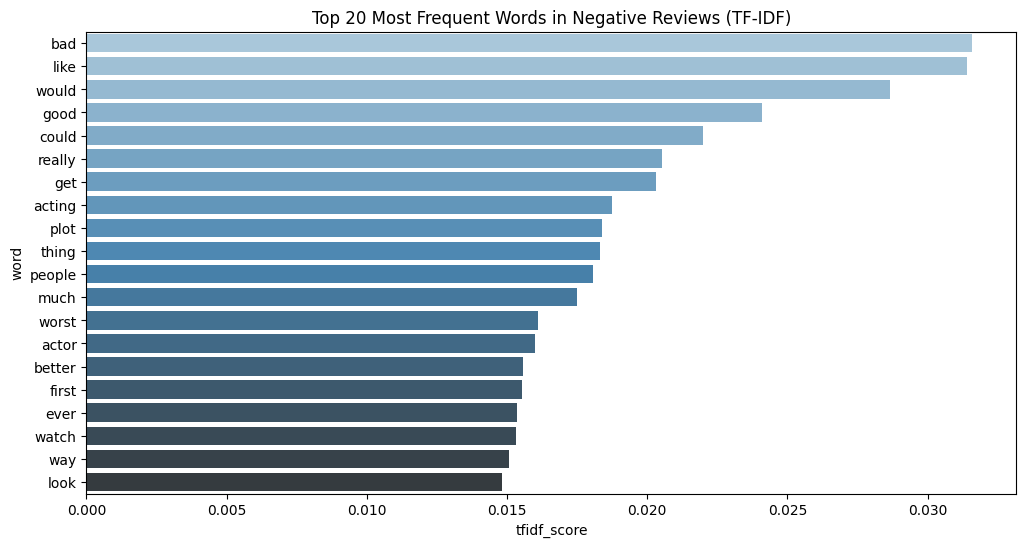

['tfidf_vectorizer.pkl']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens back into strings after removing rare tokens
processed_reviews = [" ".join(review) for review in no_rare_tokens]

# Custom stopwords (add the words you want to exclude)
custom_stopwords = ["movie", "film", "scene", "show", "one", "character", "story", "even", "time", "see", "make", "made"]

# Initialize the TfidfVectorizer, excluding custom stopwords
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=custom_stopwords)

# Fit the vectorizer and transform the reviews into TF-IDF matrix
X_tfidf = tfidf_vectorizer.fit_transform(processed_reviews)

# Convert labels (y) into a boolean mask for positive and negative reviews
positive_mask = [label == 'positive' for label in y]
negative_mask = [label == 'negative' for label in y]

# Split TF-IDF matrix into positive and negative reviews
X_tfidf_positive = X_tfidf[positive_mask]
X_tfidf_negative = X_tfidf[negative_mask]

# Function to calculate and plot most frequent words based on TF-IDF scores
def plot_most_frequent_words_tfidf(X_tfidf_subset, vectorizer, title):
    # Get the average TF-IDF scores for all words across the subset
    tfidf_scores = X_tfidf_subset.mean(axis=0).A1  # .A1 flattens the sparse matrix into a 1D array

    # Create a DataFrame of word frequencies
    word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'tfidf_score': tfidf_scores})

    # Sort by the highest TF-IDF scores
    word_freq_df = word_freq_df.sort_values(by='tfidf_score', ascending=False).head(20)

    # Plot the bar chart of most frequent words based on TF-IDF scores
    plt.figure(figsize=(12, 6))
    sns.barplot(x='tfidf_score', y='word', data=word_freq_df, palette='Blues_d')
    plt.title(title)
    plt.show()

# Plot for Positive Reviews (TF-IDF)
plot_most_frequent_words_tfidf(X_tfidf_positive, tfidf_vectorizer, "Top 20 Most Frequent Words in Positive Reviews (TF-IDF)")

# Plot for Negative Reviews (TF-IDF)
plot_most_frequent_words_tfidf(X_tfidf_negative, tfidf_vectorizer, "Top 20 Most Frequent Words in Negative Reviews (TF-IDF)")


# To save this TF-IDF method for later use
import joblib

joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


This code splits TF-IDF features into training and test sets and trains a **Logistic Regression model** to classify the reviews. It evaluates the model using accuracy, a classification report, and cross-validation accuracy.

This Logistic Regression model has a high accuracy of about 89% on average.

Logistic Regression AUC-ROC is about 96%.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # For better visualization of the confusion matrix
import pandas as pd  # For better handling of data

# Assuming X_tfidf and y are already defined from your previous code
# Split data into training and test sets (using TF-IDF features)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
LogisticRegression_model = LogisticRegression()

# Train the model on the training data
LogisticRegression_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = LogisticRegression_model.predict(X_test)
y_pred_prob = LogisticRegression_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Use cross-validation with Logistic Regression
scores = cross_val_score(LogisticRegression(), X_tfidf, y, cv=5)
print("Cross-Validation Scores:", scores)
print("Average Cross-Validation Accuracy:", scores.mean())

# Convert y_test to numerical values (0 and 1) before calculating ROC metrics
# Assuming 'positive' is the positive class
y_test_numeric = [1 if label == 'positive' else 0 for label in y_test]

# Calculate AUC-ROC using the numeric y_test
roc_auc = roc_auc_score(y_test_numeric, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_prob)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

print("Logistic Regression AUC-ROC:", roc_auc)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


NameError: name 'X_tfidf' is not defined

In [ ]:
# Save the trained model using pickle
with open('LogisticRegression_model.pkl', 'wb') as file:
    pickle.dump(LogisticRegression_model, file)

print("Model saved successfully!")

NameError: name 'pickle' is not defined

 The objective of this code is to identify and visualize misclassified examples from a classification model by comparing predicted labels with actual labels. It creates a structured DataFrame displaying the actual labels, predicted labels, and original input data for easier analysis of the model's performance.

In [ ]:
# Extract misclassified examples
misclassified_indices = [i for i in range(len(y_test)) if y_pred[i] != y_test[i]]  # Directly index y_test as it is a list

# Create a DataFrame for better visualization
misclassified_examples = pd.DataFrame({
    'Actual': [y_test[i] for i in misclassified_indices],  # Actual labels
    'Predicted': [y_pred[i] for i in misclassified_indices],  # Predicted labels
    'Text': [X_test[i] for i in misclassified_indices]  # Original text, assuming X_test is accessible
})

print("Misclassified Examples:")
print(misclassified_examples)


Misclassified Examples:
        Actual Predicted                                               Text
0     negative  positive    (0, 4653)\t0.07593077320055541\n  (0, 4493)\...
1     negative  positive    (0, 2484)\t0.061172364442881474\n  (0, 4952)...
2     positive  negative    (0, 2387)\t0.11920344585932117\n  (0, 4952)\...
3     positive  negative    (0, 4004)\t0.2056036601194785\n  (0, 2387)\t...
4     negative  positive    (0, 1073)\t0.06353294995017472\n  (0, 4653)\...
...        ...       ...                                                ...
1062  negative  positive    (0, 192)\t0.05209374253639304\n  (0, 3581)\t...
1063  positive  negative    (0, 4653)\t0.051975093834031094\n  (0, 522)\...
1064  negative  positive    (0, 184)\t0.26067291576161283\n  (0, 2989)\t...
1065  negative  positive    (0, 192)\t0.04917180035043651\n  (0, 147)\t0...
1066  negative  positive    (0, 2132)\t0.08089425051833335\n  (0, 1636)\...

[1067 rows x 3 columns]


This code is to identify misclassified instances from a classification model and create a DataFrame that links the actual labels, predicted labels, and their corresponding processed reviews, enabling better visualization and analysis of the model's classification errors.

In [ ]:
# Let's assume processed_reviews is defined like this:
# processed_reviews = ["review1 after processing", "review2 after processing", ...]

# Extract misclassified examples
misclassified_indices = [i for i in range(len(y_test)) if y_pred[i] != y_test[i]]  # Get misclassified indices

# Create a DataFrame for better visualization, linking to processed_reviews
misclassified_examples = pd.DataFrame({
    'Actual': [y_test[i] for i in misclassified_indices],  # Actual labels
    'Predicted': [y_pred[i] for i in misclassified_indices],  # Predicted labels
    'Processed Text': [processed_reviews[i] for i in misclassified_indices]  # Corresponding processed reviews
})

print("Misclassified Examples:")
print(misclassified_examples)


Misclassified Examples:
        Actual Predicted                                     Processed Text
0     negative  positive  say movie deserves anything grace showed disag...
1     negative  positive  great show despite many negative user review a...
2     positive  negative  film requires lot patience focus mood characte...
3     positive  negative  rather appalled see low rating movie received ...
4     negative  positive  wow truly fantastic notrip movie ton imagery d...
...        ...       ...                                                ...
1062  negative  positive  extremely long movie mean may become bored bec...
1063  positive  negative  normally not_a good movie kind guy saw trailer...
1064  negative  positive  privilege recently viewing said last mm techni...
1065  negative  positive  many film attempt ambitious succeed film one t...
1066  negative  positive  nothing brilliant groundbreaking innovative wo...

[1067 rows x 3 columns]


The processed text is hidden dued to column width restriction. This code is to  configure pandas to display the full content of DataFrame columns without truncation, allowing for the complete viewing of the text in the misclassified_examples DataFrame when printed.

In [ ]:
import pandas as pd

# Assuming you already have your misclassified_examples DataFrame
# Set pandas display option to show full content in columns
pd.set_option('display.max_colwidth', None)  # Set max_colwidth to None to avoid truncation

# Print your DataFrame
print(misclassified_examples)


        Actual Predicted  \
0     negative  positive   
1     negative  positive   
2     positive  negative   
3     positive  negative   
4     negative  positive   
...        ...       ...   
1062  negative  positive   
1063  positive  negative   
1064  negative  positive   
1065  negative  positive   
1066  negative  positive   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Reset the display options back to default

In [ ]:
pd.reset_option('display.max_colwidth')  # Reset to default


 Install the necessary Python libraries—pandas, scikit-learn, and nltk—using pip. These libraries are commonly used for data manipulation and analysis (pandas), machine learning (scikit-learn), and natural language processing (nltk).

In [ ]:
!pip install pandas scikit-learn nltk

This code vectorizes text reviews using TF-IDF with both unigrams and bigrams, splits the data into training and test sets, and trains a **Multinomial Naive Bayes model** for classification. It evaluates the model’s performance with accuracy and a classification report, showing predictions for a few samples.

This Naive Bayes model has a high accuracy of about 86% on average.

Multinomial Naive Bayes AUC-ROC is about 94%.







Accuracy: 0.8669
Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.86      0.86      4978
    positive       0.86      0.88      0.87      5022

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



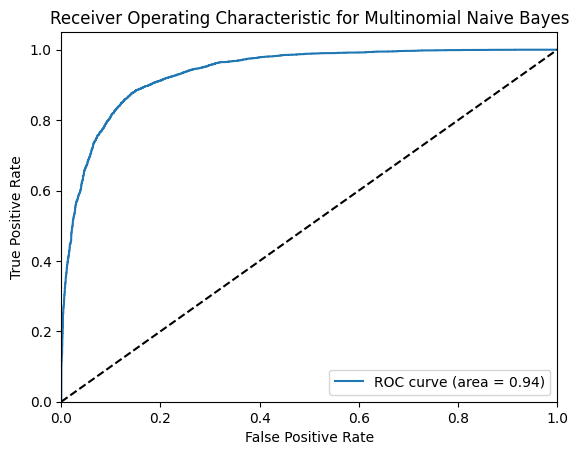

Multinomial Naive Bayes AUC-ROC: 0.9364091688815095


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming X_tfidf and y are already defined from your previous code
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize the Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Train the model on the training data
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_model.predict(X_test)
y_pred_prob = nb_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Convert y_test to numerical values (0 and 1) before calculating ROC metrics
y_test_numeric = [1 if label == 'positive' else 0 for label in y_test]

# Calculate AUC-ROC using the numeric y_test
roc_auc = roc_auc_score(y_test_numeric, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_prob)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multinomial Naive Bayes')
plt.legend(loc="lower right")
plt.show()

print("Multinomial Naive Bayes AUC-ROC:", roc_auc)


This code builds a **Convolutional Neural Network (CNN)** to classify text data by converting reviews into fixed-length numeric sequences, using an embedding and 1D convolutional layers to capture features, and applying dense layers to classify each text as positive or negative. The model is trained on labeled data, and its performance is evaluated using accuracy and a classification report, which measures precision, recall, and F1-score.

This CNN model has an accuracy of about 87%.
CNN AUC-ROC is about 95%.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 64s 59ms/step - accuracy: 0.7556 - loss: 0.4684 - val_accuracy: 0.8681 - val_loss: 0.3086
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9299 - loss: 0.1899 - val_accuracy: 0.8804 - val_loss: 0.2979
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.9840 - loss: 0.0635 - val_accuracy: 0.8767 - val_loss: 0.3811
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.9970 - loss: 0.0145 - val_accuracy: 0.8780 - val_loss: 0.4743
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 48ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 0.8800 - val_loss: 0.5209
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Accuracy: 0.8786
Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.88      0.88      4978
    positive       0.88      0.88      0.88      5022

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88 

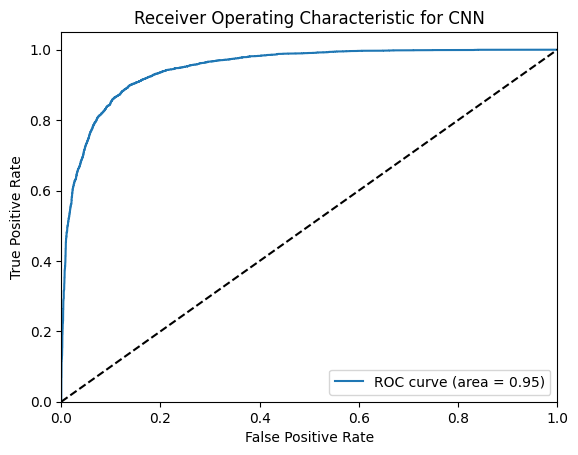

CNN AUC-ROC: 0.9486304454854245


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert categorical labels to numeric

# Step 2: Tokenize and pad the text data for CNN input
max_words = 5000   # max number of words to consider in vocabulary
max_len = 100      # max sequence length for each review

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(processed_reviews)
X_sequences = tokenizer.texts_to_sequences(processed_reviews)
X_padded = pad_sequences(X_sequences, maxlen=max_len)

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Step 4: Build the CNN model
cnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train the CNN model
cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Step 6: Make predictions on the test set
y_pred_probs = cnn_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()  # Convert probabilities to binary predictions

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Convert y_test to numerical values (0 and 1) before calculating ROC metrics
y_test_numeric = y_test  # y_test is already numeric after encoding

# Calculate AUC-ROC using the numeric y_test
roc_auc = roc_auc_score(y_test_numeric, y_pred_probs)
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_probs)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CNN')
plt.legend(loc="lower right")
plt.show()

print("CNN AUC-ROC:", roc_auc)


This code builds a **Support Vector Machine (SVM) model** to classify text data by transforming reviews into TF-IDF features, training an SVM with a linear kernel to distinguish between positive and negative classes, and evaluating the model's performance using accuracy and a classification report, which includes precision, recall, and F1-score.

This Support Vector Machine (SVM) model has a high accuracy of about 89% on average.

SVM AUC-ROC is about 96%.


Accuracy: 0.8891
Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4978
    positive       0.88      0.90      0.89      5022

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



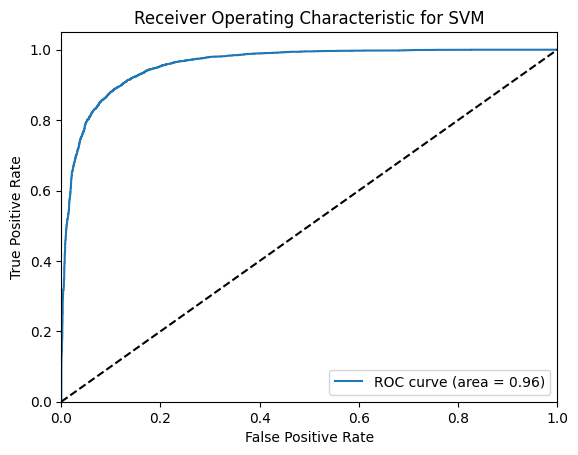

SVM AUC-ROC: 0.9585707179290991


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming X_tfidf and y are already defined from your previous code
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train the Support Vector Machine model
svm_model = SVC(kernel='linear', probability=True)  # Set probability=True to enable probability estimates
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
y_pred_prob = svm_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Convert y_test to numerical values (0 and 1) before calculating ROC metrics
y_test_numeric = [1 if label == 'positive' else 0 for label in y_test]

# Calculate AUC-ROC using the numeric y_test
roc_auc = roc_auc_score(y_test_numeric, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_prob)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVM')
plt.legend(loc="lower right")
plt.show()

print("SVM AUC-ROC:", roc_auc)


This code performs **hyperparameter tuning for a logistic regression model** using **Randomized Search Cross-Validation**. It defines a range of hyperparameters, including regularization strength (C), penalty type (l1 or l2), and solver options. The code initializes a logistic regression model, conducts a randomized search to identify the best parameter combination based on accuracy, and retrains the model with these optimized parameters. Finally, it evaluates the model's performance on a test set by calculating accuracy, generating a classification report, and computing the AUC-ROC score to assess its predictive capabilities.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
import numpy as np

# Define the parameter distribution for hyperparameter tuning
param_dist = {
    'C': uniform(loc=0.001, scale=10),          # Sampling from a continuous range for regularization strength
    'penalty': ['l1', 'l2'],                    # Regularization type (l1, l2)
    'solver': ['liblinear', 'saga']             # Solver that supports 'l1' or 'l2' penalties
}

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Initialize RandomizedSearchCV with the model and parameter distribution
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,               # Number of parameter combinations to try
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Re-train model with best parameters on the training set
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions and evaluate the optimized model
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Evaluate accuracy and ROC AUC
print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test_numeric, y_pred_prob)
print("Optimized Logistic Regression AUC-ROC:", roc_auc)

Best Parameters: {'C': 2.8103450968738075, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.89035
Optimized Model Accuracy: 0.8924
Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4978
    positive       0.89      0.90      0.89      5022

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Optimized Logistic Regression AUC-ROC: 0.9598537427684599


Logistic model has the highest accuracy and highest AUC-ROC value hence we will be using this model for other experiment.


We will first save the trained logistic regression model to test it on another dataset.

Save it to a file with joblib.dump.

In [ ]:
import joblib

# Save the trained model to a file
joblib.dump(LogisticRegression_model, 'logistic_regression_model.joblib')


['logistic_regression_model.joblib']

To use the saved model on a new dataset, load it back into your script using joblib.load.

In [ ]:
# Load the model from the file
loaded_model = joblib.load('logistic_regression_model.joblib')



To evaluate the model’s portability across different types of reviews, we will train it exclusively on the movie reviews dataset and then test it on a separate dataset of 51,000+ user reviews of the Spotify application. This approach will allow us to assess the model’s **generalization capabilities and robustness** when applied to new, unseen data from a different domain. By testing on a diverse dataset, we aim to understand how well the model can handle varying review contexts without overfitting to a single domain, ultimately improving its adaptability and performance.

This code extracts a dataset from a zip file, loads it as a DataFrame, and separates reviews and their sentiment labels. It then balances the dataset by sampling **20,000 positive and 20,000 negative reviews.** Finally, it combines these samples into a new dataset and verifies the data with sample outputs, preparing it for analysis or model training.


In [ ]:
import pandas as pd
import os
import zipfile

# If the dataset is in a zip file, extract it first
zip_path = '/content/drive/MyDrive/archive.zip'
extract_dir = '/content/archive'  # Directory to extract the CSV file

# Unzipping the file if needed
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Check extracted files to confirm
print("Extracted files:", os.listdir(extract_dir))

# Load the CSV file (update the name if necessary)
csv_file_path = os.path.join(extract_dir, 'DATASET.csv')
spotify_reviews = pd.read_csv(csv_file_path)

# Preview the data to confirm it's loaded correctly
print(spotify_reviews.head())

# Extract features (reviews) and labels (sentiment)
rev = spotify_reviews['Review']  # Replace 'Review' with the actual column name if different
sen = spotify_reviews['label']   # Replace 'label' with the actual column name if different

# Verify the data
print(rev.head())
print(sen.head())

# Separate positive and negative reviews
s_positive_reviews = spotify_reviews[spotify_reviews['label'] == 'POSITIVE']['Review'].tolist()
s_negative_reviews = spotify_reviews[spotify_reviews['label'] == 'NEGATIVE']['Review'].tolist()

# Extract 20,000 positive and 20,000 negative reviews
s_positive_subset = s_positive_reviews[:20000]
s_negative_subset = s_negative_reviews[:20000]

# Combine reviews and labels into a new variable
combined_reviews = s_positive_subset + s_negative_subset
combined_labels = ['POSITIVE'] * 20000 + ['NEGATIVE'] * 20000

print(f"Total combined reviews: {len(combined_reviews)}")
print(f"Sample reviews:\n", combined_reviews[:5])
print(f"Sample labels:\n", combined_labels[:5])



Extracted files: ['DATASET.csv']
                                              Review     label
0  Great music service, the audio is high quality...  POSITIVE
1  Please ignore previous negative rating. This a...  POSITIVE
2  This pop-up "Get the best Spotify experience o...  NEGATIVE
3    Really buggy and terrible to use as of recently  NEGATIVE
4  Dear Spotify why do I get songs that I didn't ...  NEGATIVE
0    Great music service, the audio is high quality...
1    Please ignore previous negative rating. This a...
2    This pop-up "Get the best Spotify experience o...
3      Really buggy and terrible to use as of recently
4    Dear Spotify why do I get songs that I didn't ...
Name: Review, dtype: object
0    POSITIVE
1    POSITIVE
2    NEGATIVE
3    NEGATIVE
4    NEGATIVE
Name: label, dtype: object
Total combined reviews: 40000
Sample reviews:
 ['Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.', 'Please ignore previous n

The first step is to clean up any HTML tags that might exist within the text reviews. Use the function remove_html_tags to strip tags like <br> or other similar elements.

In [ ]:
# Function to remove HTML tags
def remove_html_tags(text):
    return text.replace("<br />", " ").replace("<br>", " ")

# Apply to your Spotify reviews
no_html_reviews = [remove_html_tags(review) for review in combined_reviews]


Next, expand common contractions to ensure that the reviews are more readable and standardized.

In [ ]:
# Function to expand contractions
def expand_contractions(text, contractions=contractions_dict):
    contraction_pattern = re.compile('({})'.format('|'.join(contractions.keys())), flags=re.IGNORECASE|re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0).lower()
        expanded_contraction = contractions.get(match)
        return expanded_contraction

    expanded_text = contraction_pattern.sub(expand_match, text)
    return expanded_text

# Apply to the Spotify reviews
expanded_contractions = [expand_contractions(review) for review in no_html_reviews]


Clean the reviews by removing special characters and numbers, then convert them to lowercase.

In [ ]:
# Function to remove special characters and convert to lowercase
def remove_special_chars_and_lowercase(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()

cleaned_reviews = [remove_special_chars_and_lowercase(review) for review in expanded_contractions]


Tokenize each review, breaking down each cleaned review into a list of words.

In [ ]:
# Tokenize text
tokenized_reviews = [tokenize_text(review) for review in cleaned_reviews]


Apply the negation handling function to detect words following negations (e.g., "not happy" becomes "not_happy").

In [ ]:
# Handle negations
reviews_with_negations_handled = [handle_negations(review) for review in tokenized_reviews]


Remove common stopwords to focus on meaningful words.

In [ ]:
# Remove stopwords
filtered_reviews = [remove_stopwords(review) for review in reviews_with_negations_handled]


Lemmatize the words in each review to reduce them to their base form, making the reviews more uniform.

In [ ]:
# Lemmatize tokens
lemmatized_reviews = [lemmatize_tokens(review) for review in filtered_reviews]


To reduce noise, filter out words that appear too infrequently.

In [ ]:
# Remove rare words
no_rare_tokens = remove_rare_words(lemmatized_reviews, min_freq=2)


Lastly, remove any reviews that might be empty after the cleaning process.

In [ ]:
# Remove missing reviews
cleaned_reviews_no_missing = remove_missing_reviews(no_rare_tokens)


Now, cleaned_reviews_no_missing will contain your final cleaned Spotify reviews, ready for TF-IDF or any further analysis.

In [ ]:
print(f"Number of cleaned reviews: {len(cleaned_reviews_no_missing)}")
print(f"Sample cleaned reviews:\n", cleaned_reviews_no_missing[:5])


Number of cleaned reviews: 39977
Sample cleaned reviews:
 [['great', 'music', 'service', 'audio', 'high', 'quality', 'app', 'easy', 'use', 'also', 'quick', 'friendly', 'support'], ['please', 'ignore', 'previous', 'negative', 'rating', 'app', 'super', 'great', 'give', 'five', 'star'], ['love', 'selection', 'lyric', 'provided', 'song', 'listening'], ['great', 'app', 'best', 'mp', 'music', 'app', 'ever', 'used', 'one', 'problem', 'not_we', 'play', 'song', 'find', 'song', 'despite', 'app', 'wonderful', 'recommend', 'best'], ['hav', 'music', 'like', 'super']]


This code loads a previously saved TF-IDF vectorizer (tfidf_vectorizer.pkl) and uses it to transform new text data (combined_reviews) into TF-IDF features.

This transformed data (new_X_tfidf) can then be used as input for machine learning models trained with similar TF-IDF features.

In [ ]:
# Load the saved vectorizer
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Join tokens back into single strings
cleaned_reviews_strings = [" ".join(review) for review in cleaned_reviews_no_missing]

# Transform the new data using the loaded vectorizer
new_X_tfidf = tfidf_vectorizer.transform(cleaned_reviews_strings)



This code evaluates a **machine learning model's performance on new data** using several metrics. It starts by making predictions (new_predictions) and obtaining prediction probabilities (new_predictions_prob). True labels are converted to binary (1 for positive, 0 for negative) to match the predicted labels.

**Key evaluations include:**


1.   Accuracy: Measures the percentage of correct predictions.
2.   Classification Report: Provides precision, recall, and F1-score for each class.
AUC-ROC: Calculates the Area Under the ROC Curve, assessing the model's ability to distinguish between classes.
3. ROC Curve Plot: Visualizes the trade-off between the true positive rate (TPR) and false positive rate (FPR), with the AUC as an indicator of model performance.


The ROC curve is then plotted, giving insight into the model’s performance across various threshold levels.








The model's performance on the new dataset shows an accuracy of 0.5, meaning it correctly classified 50% of the samples. However, the classification report indicates that the model has significant issues: it achieves perfect recall for class 0 (negative), but fails to identify any positive samples (class 1). This leads to undefined precision for class 1, which results in an F1-score of 0.0 for this class.

Despite this, the model's AUC-ROC score is high (0.86), suggesting that while it differentiates between classes well on a probabilistic level, it does not translate this to accurate class predictions. This could indicate thresholding or class imbalance issues that prevent the model from adequately capturing the positive class.

Length of true_labels: 39977
Length of predicted_labels: 39977
Accuracy on new data: 0.4997123345923906
Classification Report on new data:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67     19977
           1       0.00      0.00      0.00     20000

    accuracy                           0.50     39977
   macro avg       0.25      0.50      0.33     39977
weighted avg       0.25      0.50      0.33     39977

AUC-ROC on new data: 0.8757233944035642


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


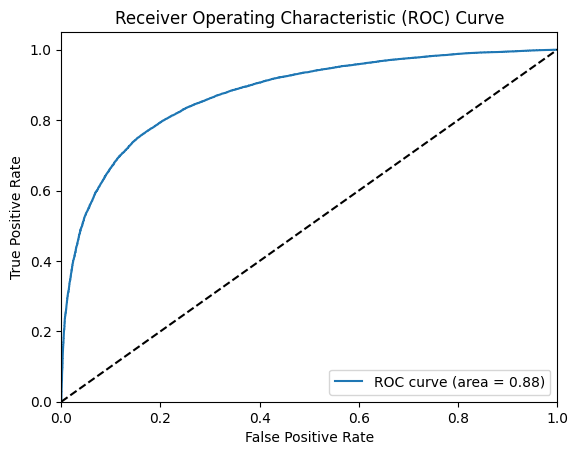

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Make predictions and get probabilities on the new data
new_predictions = loaded_model.predict(new_X_tfidf)
new_predictions_prob = loaded_model.predict_proba(new_X_tfidf)[:, 1]  # Get probabilities for the positive class

# Adjust `combined_labels` to match the length of `cleaned_reviews_no_missing`
adjusted_labels = [combined_labels[i] for i in range(len(cleaned_reviews_no_missing))]

# Convert adjusted labels and predictions to binary format (0 and 1)
true_labels = [1 if label == 'POSITIVE' else 0 for label in adjusted_labels]  # Convert true labels
predicted_labels = [1 if label == 'POSITIVE' else 0 for label in new_predictions]  # Convert predictions

# Check for matching lengths
print(f"Length of true_labels: {len(true_labels)}")
print(f"Length of predicted_labels: {len(predicted_labels)}")

# Calculate and print accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy on new data:", accuracy)

# Generate and print classification report
print("Classification Report on new data:\n", classification_report(true_labels, predicted_labels))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(true_labels, new_predictions_prob)
print("AUC-ROC on new data:", roc_auc)

# Calculate ROC Curve values
fpr, tpr, _ = roc_curve(true_labels, new_predictions_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
